In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

cifar = fetch_openml('CIFAR_10', version=1, as_frame=False)

X = cifar['data']
y = cifar['target'].astype(int)

X_images = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

Kształt danych: (60000, 32, 32, 3)
Przykładowa etykieta: 8
Typ danych obrazów: int64
Kanały kolorów:  3


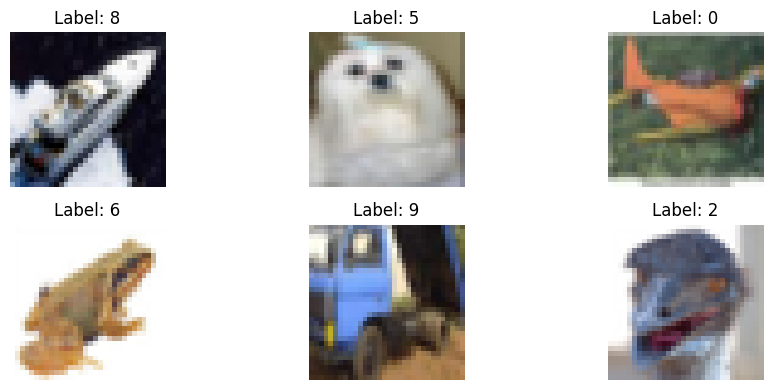

In [2]:
print("Kształt danych:", X_images.shape)
print("Przykładowa etykieta:", y[0])
print("Typ danych obrazów:", X_images[0].dtype)
print("Kanały kolorów: ", X_images.shape[-1])

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_images[i])
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Dataset zawiera 60000 obrazków.<br>
Każdy z obrazków jest w wymiarze 32x32 piksele, posiadając 3 kanały kolorów (RGB). <br>
W zbiorze obrazki etykietowane są numerycznie, posiadają 10 podstawowych klas, cyfry oznaczają następujące kategorie obrazów:

### Kategorie CIFAR-10

0 – airplane  
1 – automobile  
2 – bird  
3 – cat  
4 – deer  
5 – dog  
6 – frog  
7 – horse  
8 – ship  
9 – truck


In [3]:
image_shapes = {x.shape for x in X_images}
print("Unikalne rozmiary obrazów:", image_shapes)

Unikalne rozmiary obrazów: {(32, 32, 3)}


Każdy z obrazów jest w rozmiarach 32x32, więc nie potrzebuje przeskalowania. Jedynie jeśli będzie to potrzebne dla efektywniejszej ewaluacji modelu.

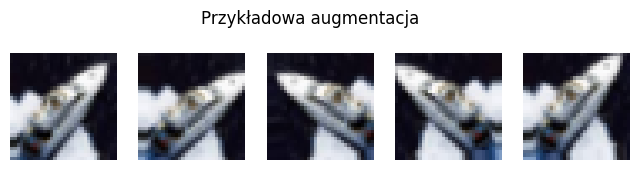

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_images)

sample = X_images[0].reshape((1, 32, 32, 3))
aug_iter = datagen.flow(sample, batch_size=1)

plt.figure(figsize=(8, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    augmented = next(aug_iter)[0].astype("uint8")
    plt.imshow(augmented)
    plt.axis("off")
plt.suptitle("Przykładowa augmentacja")
plt.show()

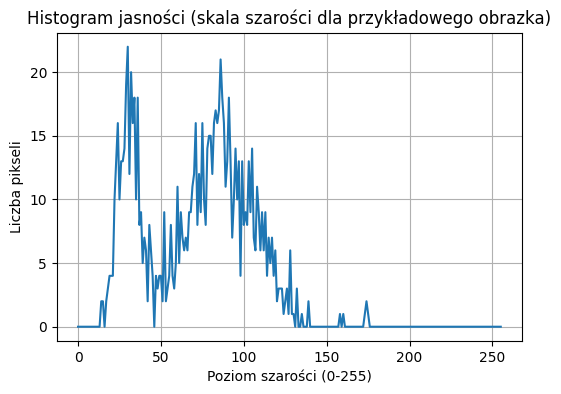

In [5]:
import cv2
from matplotlib import pyplot as plt

img = X_images[2137].astype('uint8')

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])

plt.figure(figsize=(6, 4))
plt.plot(hist)
plt.title("Histogram jasności (skala szarości dla przykładowego obrazka)")
plt.xlabel("Poziom szarości (0-255)")
plt.ylabel("Liczba pikseli")
plt.grid()
plt.show()

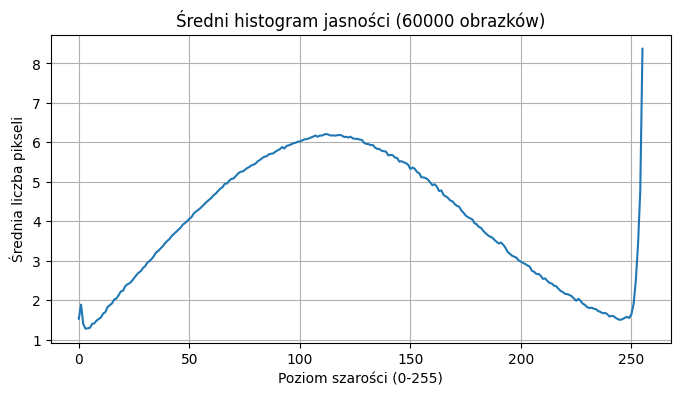

In [6]:
hist_total = np.zeros((256, 1))
n = X.shape[0]

for i in range(n):
    gray = cv2.cvtColor(X_images[i].astype('uint8'), cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_total += hist

hist_total /= n

plt.figure(figsize=(8, 4))
plt.plot(hist_total)
plt.title("Średni histogram jasności (" + str(n) + " obrazków)")
plt.xlabel("Poziom szarości (0-255)")
plt.ylabel("Średnia liczba pikseli")
plt.grid()
plt.show()

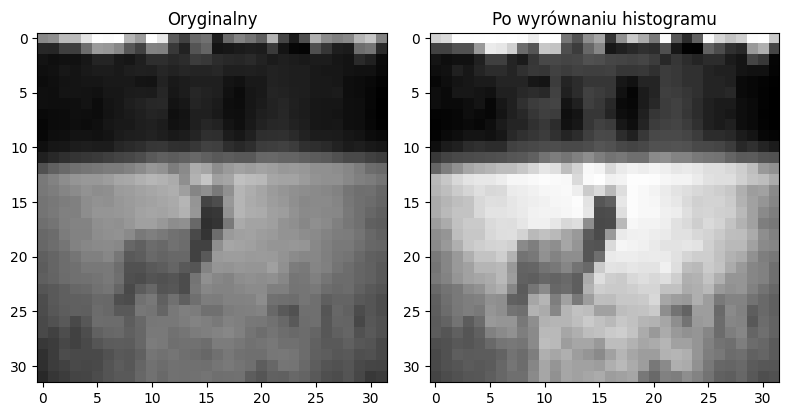

In [7]:
equalized_img = cv2.equalizeHist(gray_img)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title("Oryginalny")

plt.subplot(1, 2, 2)
plt.imshow(equalized_img, cmap='gray')
plt.title("Po wyrównaniu histogramu")

plt.tight_layout()
plt.show()

HOG + LBP + PCA i uczenie

In [9]:
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def get_hog_features(img):
    gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
    return hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)


def get_lbp_features(img):
    gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    return hist / np.sum(hist)


def extract_features(X):
    hog_feats = np.array([get_hog_features(img) for img in X])
    lbp_feats = np.array([get_lbp_features(img) for img in X])

    X_features = np.concatenate([hog_feats, lbp_feats], axis=1)

    pca = PCA(n_components=40)
    return pca.fit_transform(X_features)


X_features = extract_features(X_images)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=2137)

In [10]:
def f1_score(y_true, y_pred):
    labels = sorted(set(y_true) | set(y_pred))

    f1_sum = 0.0
    for lbl in labels:
        tp = sum((yt == lbl and yp == lbl) for yt, yp in zip(y_true, y_pred))
        fp = sum((yt != lbl and yp == lbl) for yt, yp in zip(y_true, y_pred))
        fn = sum((yt == lbl and yp != lbl) for yt, yp in zip(y_true, y_pred))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        f1_sum += f1

    return f1_sum / len(labels)

### XGBoost

In [11]:
from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
xgboost_fscore = f1_score(y_test, list(y_pred))

print(f"fscore: {xgboost_fscore:.3f}")

fscore: 0.532


In [12]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
catboost_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {catboost_fscore:.3f}")

Learning rate set to 0.096398
0:	learn: 2.2351843	total: 102ms	remaining: 1m 41s
1:	learn: 2.1735183	total: 133ms	remaining: 1m 6s
2:	learn: 2.1234729	total: 169ms	remaining: 56.1s
3:	learn: 2.0839222	total: 201ms	remaining: 50.1s
4:	learn: 2.0471126	total: 238ms	remaining: 47.4s
5:	learn: 2.0133559	total: 281ms	remaining: 46.5s
6:	learn: 1.9834768	total: 316ms	remaining: 44.9s
7:	learn: 1.9582647	total: 350ms	remaining: 43.4s
8:	learn: 1.9335679	total: 385ms	remaining: 42.4s
9:	learn: 1.9114464	total: 422ms	remaining: 41.8s
10:	learn: 1.8922513	total: 474ms	remaining: 42.6s
11:	learn: 1.8739250	total: 519ms	remaining: 42.8s
12:	learn: 1.8559148	total: 565ms	remaining: 42.9s
13:	learn: 1.8397436	total: 605ms	remaining: 42.6s
14:	learn: 1.8242045	total: 658ms	remaining: 43.2s
15:	learn: 1.8089188	total: 703ms	remaining: 43.2s
16:	learn: 1.7962862	total: 733ms	remaining: 42.4s
17:	learn: 1.7862959	total: 764ms	remaining: 41.7s
18:	learn: 1.7755889	total: 798ms	remaining: 41.2s
19:	learn:

### AdaBoost

In [13]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
ada_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {ada_fscore:.3f}")

fscore: 0.300


### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rf_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {rf_fscore:.3f}")

fscore: 0.487


### KNeighbors

In [15]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
kn_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {kn_fscore:.3f}")

fscore: 0.483


### NuSVC

In [16]:
from sklearn.svm import NuSVC

model = NuSVC()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
nu_fscore = f1_score(y_test, y_pred.flatten().tolist())

print(f"fscore: {nu_fscore:.3f}")

fscore: 0.546


### Podsumowanie

In [17]:
import pandas as pd

models = [
    "xgboost",
    "catboost",
    "adaboost",
    "random forest",
    "k neighbors",
    "nusvc"
]

scores = [
    xgboost_fscore,
    catboost_fscore,
    ada_fscore,
    rf_fscore,
    kn_fscore,
    nu_fscore
]

pd.DataFrame({
    "model": models,
    "f1-score": scores
})

,model,f1-score
0,xgboost,0.532110
1,catboost,0.560924
2,adaboost,0.300499
3,random forest,0.487425
4,k neighbors,0.482770
5,nusvc,0.545868


Najlepszy okazał się catboost osiągając wynik f1-score na poziomie: **0.561**

In [ ]:
from sklearn.model_selection import cross_val_score

model = CatBoostClassifier(iterations=200)

scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title('Cross-Validation F1 Scores per Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(range(1, len(scores) + 1))
plt.grid()
plt.show()


Learning rate set to 0.375575
0:	learn: 2.1516499	total: 3.41s	remaining: 11m 18s
1:	learn: 2.0626627	total: 11s	remaining: 18m 12s
Learning rate set to 0.375575
Learning rate set to 0.375575
Learning rate set to 0.375575
Learning rate set to 0.375575
2:	learn: 2.0043525	total: 20.9s	remaining: 22m 49s
0:	learn: 2.1466197	total: 9.68s	remaining: 32m 6s
0:	learn: 2.1490166	total: 9.88s	remaining: 32m 45s
0:	learn: 2.1492774	total: 10.1s	remaining: 33m 20s
0:	learn: 2.1506421	total: 9.95s	remaining: 32m 59s
1:	learn: 2.0609220	total: 18.9s	remaining: 31m 10s
3:	learn: 1.9555004	total: 30.3s	remaining: 24m 46s
1:	learn: 2.0672606	total: 19s	remaining: 31m 23s
1:	learn: 2.0657485	total: 19.4s	remaining: 31m 57s
1:	learn: 2.0635796	total: 19.5s	remaining: 32m 7s
2:	learn: 2.0092995	total: 28.9s	remaining: 31m 38s
2:	learn: 2.0041440	total: 29s	remaining: 31m 47s
4:	learn: 1.9171228	total: 40.5s	remaining: 26m 20s
2:	learn: 2.0113376	total: 29.6s	remaining: 32m 20s
2:	learn: 2.0031393	total:

### Macierz koleracji

In [ ]:
corr = np.corrcoef(X_features, rowvar=False)

plt.figure(figsize=(10, 10))
plt.imshow(corr, interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson r')
plt.title("Feature Correlation Matrix")
plt.xticks(range(X_features.shape[1]), [f"f{i}" for i in range(X_features.shape[1])], rotation=90)
plt.yticks(range(X_features.shape[1]), [f"f{i}" for i in range(X_features.shape[1])])
plt.tight_layout()
plt.show()

Jak widać na załączonym wykresie, żadna z cech nie jest ze sobą powiązana.

## Optymalizacja parametrów

### Grid search

In [41]:
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(verbose=True, random_seed=2137)

param_grid = {
    'learning_rate':       [0.01, 0.05, 0.1],
    'depth':               [4, 6, 8],
    'l2_leaf_reg':         [1, 3, 5],
    'iterations':          [100, 300, 500],
    'bagging_temperature': [0.0, 1.0, 2.0],
    'random_strength':     [0, 1, 2]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

fscore = f1_score(y_test, y_pred.flatten().tolist())
print(f"fscore: {fscore:.3f}")

0:	learn: 2.2653457	total: 262ms	remaining: 4m 22s
1:	learn: 2.2317431	total: 474ms	remaining: 3m 56s
2:	learn: 2.2007070	total: 665ms	remaining: 3m 41s
3:	learn: 2.1736550	total: 887ms	remaining: 3m 40s
4:	learn: 2.1466050	total: 1.14s	remaining: 3m 47s
5:	learn: 2.1217918	total: 1.34s	remaining: 3m 41s
6:	learn: 2.0987445	total: 1.53s	remaining: 3m 37s
7:	learn: 2.0786603	total: 1.7s	remaining: 3m 31s
8:	learn: 2.0594412	total: 1.9s	remaining: 3m 29s
9:	learn: 2.0411544	total: 2.11s	remaining: 3m 28s
10:	learn: 2.0244425	total: 2.3s	remaining: 3m 26s
11:	learn: 2.0095579	total: 2.46s	remaining: 3m 22s
12:	learn: 1.9938360	total: 2.65s	remaining: 3m 20s
13:	learn: 1.9803003	total: 2.88s	remaining: 3m 23s
14:	learn: 1.9675308	total: 3.09s	remaining: 3m 22s
15:	learn: 1.9549893	total: 3.27s	remaining: 3m 21s
16:	learn: 1.9426707	total: 3.48s	remaining: 3m 21s
17:	learn: 1.9312570	total: 3.63s	remaining: 3m 17s
18:	learn: 1.9202630	total: 3.79s	remaining: 3m 15s
19:	learn: 1.9096241	tota

### Optuna

In [40]:
import optuna

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "verbose": 0,
        "task_type": "CPU",
        "random_seed": 2137,
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

    preds = model.predict(X_test).flatten().tolist()
    return f1_score(y_test, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)
print("Best f1-score:", study.best_value)

best_model = CatBoostClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test).flatten().tolist()
print("Final test f1-score:", f1_score(y_test, y_pred))

[I 2025-06-13 21:08:51,013] A new study created in memory with name: no-name-4718d32c-aa2a-4f4d-986a-2ad68782c102
[I 2025-06-13 21:10:02,062] Trial 0 finished with value: 0.5196217966628994 and parameters: {'iterations': 533, 'depth': 9, 'learning_rate': 0.02110705202806667, 'l2_leaf_reg': 4.165390045491072, 'random_strength': 0.002959138852261823, 'bagging_temperature': 0.2801794544681516}. Best is trial 0 with value: 0.5196217966628994.


Best parameters: {'iterations': 533, 'depth': 9, 'learning_rate': 0.02110705202806667, 'l2_leaf_reg': 4.165390045491072, 'random_strength': 0.002959138852261823, 'bagging_temperature': 0.2801794544681516}
Best f1-score: 0.5196217966628994
0:	learn: 2.2836056	total: 137ms	remaining: 1m 12s
1:	learn: 2.2657227	total: 278ms	remaining: 1m 13s
2:	learn: 2.2485291	total: 411ms	remaining: 1m 12s
3:	learn: 2.2321502	total: 536ms	remaining: 1m 10s
4:	learn: 2.2159597	total: 651ms	remaining: 1m 8s
5:	learn: 2.2003851	total: 773ms	remaining: 1m 7s
6:	learn: 2.1857319	total: 896ms	remaining: 1m 7s
7:	learn: 2.1715299	total: 1.02s	remaining: 1m 6s
8:	learn: 2.1584850	total: 1.14s	remaining: 1m 6s
9:	learn: 2.1455777	total: 1.26s	remaining: 1m 6s
10:	learn: 2.1328300	total: 1.4s	remaining: 1m 6s
11:	learn: 2.1209812	total: 1.52s	remaining: 1m 5s
12:	learn: 2.1085821	total: 1.64s	remaining: 1m 5s
13:	learn: 2.0969024	total: 1.77s	remaining: 1m 5s
14:	learn: 2.0855170	total: 1.9s	remaining: 1m 5s
15:	

### Genetic Algorithm

In [52]:
import pygad
import numpy as np
from catboost import CatBoostClassifier


param_bounds = {
    "depth": (4, 10),
    "learning_rate": (0.01, 0.3),
    "l2_leaf_reg": (1.0, 10.0),
    "iterations": (100, 500),
    "border_count": (32, 255),
    "random_strength": (1e-3, 10),
    "bagging_temperature": (0.0, 1.0)
}

param_names = list(param_bounds.keys())

def decode_chromosome(solution):
    params = {}
    for i, key in enumerate(param_names):
        low, high = param_bounds[key]
        val = solution[i]
        val = max(min(val, high), low)

        if key in ["depth", "iterations", "border_count"]:
            params[key] = int(round(val))
        else:
            params[key] = float(val)

    params["verbose"] = 0
    params["random_seed"] = 2137
    params["task_type"] = "CPU"
    return params


def fitness_func(ga_instance, solution, solution_idx):
    params = decode_chromosome(solution)
    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=20,
        verbose=0
    )
    preds = model.predict(X_test).flatten().tolist()
    return f1_score(y_test, preds)


def on_generation(ga_instance):
    best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {best_solution_fitness}")
    print("Best solution parameters:")
    decoded_params = decode_chromosome(best_solution)
    for k, v in decoded_params.items():
        print(f"  {k}: {v}")
    print("-" * 30)


num_generations = 20
num_parents_mating = 5
sol_per_pop = 10
num_genes = len(param_names)

gene_space = [
    {"low": param_bounds[name][0], "high": param_bounds[name][1]}
    for name in param_names
]

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=gene_space,
    keep_elitism=2,
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=20,
    random_seed=2137,
    parallel_processing=["thread", 5],
    on_generation=on_generation,
)

ga_instance.run()

best_solution, best_solution_fitness, _ = ga_instance.best_solution()
best_params = decode_chromosome(best_solution)
print("Best Parameters found by PyGAD:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"Best F1-score: {best_solution_fitness}")


KeyboardInterrupt: 